In [4]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model, Sequential
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

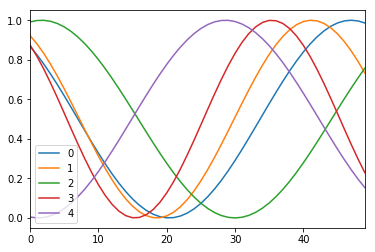

In [12]:
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [13]:
def get_gerador():
    model = Sequential()
    model.add(Dense(200, input_shape=(10,),activation='linear'))
    model.add(Activation('tanh'))
    model.add(Dense(50,activation='linear'))
    model.compile(optimizer=SGD(lr=1e-3),loss='binary_crossentropy')
    return model

In [14]:
G = get_gerador()
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [15]:
def get_discriminador():
    model = Sequential()
    model.add(Reshape((-1, 1), input_shape=(50,)))
    model.add(Conv1D(50, 5))
    model.add(Dropout(.25))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=Adam(lr=1e-3),loss='binary_crossentropy')
    return model    

In [16]:
D = get_discriminador()
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total params: 115,452
Trainable params: 115,452
Non-trainable params: 0
_________________________________________________________________


In [17]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

In [18]:
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out


GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 50)                12250     
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [19]:
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

In [20]:
def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)


In [21]:
pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 5s - loss: 0.0063     


In [22]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

In [23]:
def train(GAN, G, D, epochs=10, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

In [24]:
d_loss, g_loss = train(GAN, G, D, verbose=True)

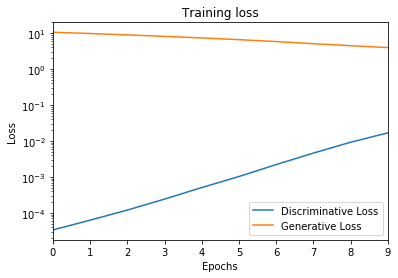

In [25]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

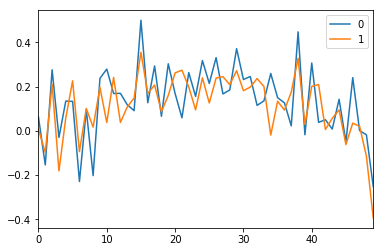

In [26]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

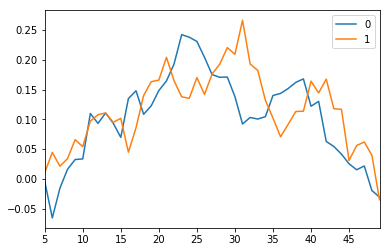

In [27]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()